# Postprocess SuperLearner results

We have run several ModEx iterations and now we need to visualize the results! This notebook assumes that all the ModEx iterations have been staged back to a single location and are present at the same time (rather than using `git checkout <sha1>` and [browsing the repository in detached head status](https://stackoverflow.com/questions/7539130/go-to-particular-revision)).

There are two main tasks done here:
1. Consolidating the `hold-out-metrics` for each machine learning model created during the workflow so we can plot the evolution of the "score" of the ML models with each ModEx iteration. The plot is also done here.
2. Consolidating the data in `sl_pca.csv` (i.e. the `combined.metric` used to evaluate the relative "importance" of all potential sites) so we can visualize the progression of the `combined.metric` on a site-by-site basis. Only the consolidation is done here; the final map plotting is gone in [GMT](https://www.generic-mapping-tools.org/) in `./make_poster_maps.sh`, so not in this notebook.

In [16]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Consolidate `hold-out-metrics`

The `hold-out-metric` is the model score when the model makes predictions with test data (data **not** used to train the model); it is therefore an estimate of the performance of the model when it is used to make predictions with new data the model has not yet seen.  We need to repeat the training/evaluation process so that different subsets of the input data are used to train and test the model. Here, we need to collect the `hold-out-metric` from each instance of the SuperLearner and then we will find the average and standard devitation associated with each ModEx iteration.

The first cell below consolidates the data.  The second cell below plots from the consolidated data.

In [2]:
# Define the basedir for the ModEx iteration jobs
basedir = "/pw/jobs/"
infix = "/ml_models/sl_"
postfix = "/hold-out-metrics.json"
num_models = 10
modex_branch_dict = {
    "modex_random_add": [57042, 57043, 57044, 57045, 57046],
    "modex_ordered_add": [57048, 57049, 57050, 57051, 57052]
}

# Loop over each branch
for branch in list(modex_branch_dict.keys()):
    print("Working on branch "+branch)
    
    # Open output file
    with open(branch+".xyz", "a") as out_file:
        # Write header line
        out_file.write("iter avg std\n")
    
        # Loop over each ModEx random add iteration
        for count, job in enumerate(list(modex_branch_dict[branch])):
            print("Working on job "+str(job))
            
            # Allocate empty list
            hold_out = []

            for model in range(0, num_models, 1):
                with open(basedir+str(job)+infix+str(model)+postfix, 'r') as in_file:
                    # Load hold out metric from JSON file
                    raw_hold_out = list(json.load(in_file).values())[0]
            
                    # If this value is less than zero, make it zero
                    # (Applied to models that do worse than a
                    # "persistance forecast")
                    if raw_hold_out < 0:
                        hold_out.append(0)
                    else:
                        hold_out.append(raw_hold_out)
            
                    # Helpful for debugging
                    #print(str(count)+"   "+str(raw_hold_out)+"--->"+str(hold_out))
                
            # Write output
            out_file.write(str(count)+" "+str(np.average(hold_out))+" "+str(np.std(hold_out))+"\n")
print("Done!")

Working on branch modex_random_add
Working on job 57042
Working on job 57043
Working on job 57044
Working on job 57045
Working on job 57046
Working on branch modex_ordered_add
Working on job 57048
Working on job 57049
Working on job 57050
Working on job 57051
Working on job 57052
Done!


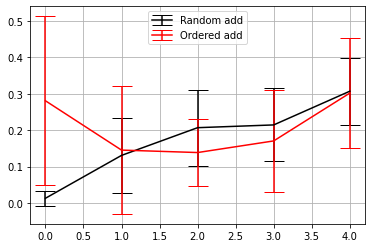

In [3]:
# Load data saved above
modex_random_add = pd.read_csv('modex_random_add.xyz', sep=" ", )
modex_ordered_add = pd.read_csv('modex_ordered_add.xyz', sep=" ", )

# Plot data
fig, ax = plt.subplots()
plt.errorbar(modex_random_add['iter'],modex_random_add['avg'],yerr=modex_random_add['std'],xerr=None,fmt='k-',capsize=10)
plt.errorbar(modex_ordered_add['iter'],modex_ordered_add['avg'],yerr=modex_ordered_add['std'],xerr=None,fmt='r-',capsize=10)
ax.legend(["Random add","Ordered add"])
ax.grid()
plt.savefig('model_score_vs_modex_iter.png')

# Consolidate `sl_pca.csv` results

The last step in the [ModEx SuperLearner workflow](https://github.com/parallelworks/sl_core/blob/main/train_predict_eval.sh) is to use principal component analysis (PCA) along with error estimates for the predictions to create a `combined.metric` that predicts the "potential importance" of a possible new data point. If a data point is relatively different from other data points (as quantified by its distance from the PCA centroid) and it has a relatively large predicted error, we hypothesize that this data point would add valuable information to the machine learning.  If these data points with relatively high `combined.metric` are prioritized as data are added to the machine learning, then we expect models trained with the priority (i.e. "important") data points will perform better than models trained with less of these priority data points.

Plotting the `hold-out-metrics` (above) is one "global" way to assess the evolution of the models. However, it may also be interesting to look for patterns in the progression/stability/volitility of the `combined.metric` on a site-by-site basis.  Are there sites that are consistently, over the course of the ModEx iterations, ranked as "high (low) priority"? Are there sites whose priority grows (decreases) consistently over the course of the ModEx iterations? We plan to evaluate both questions in light of any geospatial patterns in the distribution of these sites. 

In [95]:
# Define the basedir for the ModEx iteration jobs
basedir = "/pw/jobs/"
infix = "/ml_models/sl_"
postfix = "/sl_pca.csv"
num_models = 10
modex_branch_dict = {
    "modex_random_add": [57042, 57043, 57044, 57045, 57046],
    "modex_ordered_add": [57048, 57049, 57050, 57051, 57052]
}

# Loop over each branch
for branch in list(modex_branch_dict.keys()):
    print("Working on branch "+branch)
    
    # Allocate a blank dataframe to store combined 
    # metric for each site for each iteration
    all_iter_df = pd.DataFrame({"ID": []})
    
    # Loop over each ModEx random add iteration
    for count, job in enumerate(list(modex_branch_dict[branch])):
        print("Working on job "+str(job))

        for model in range(0, num_models, 1):
            one_iter_df = pd.read_csv(basedir+str(job)+infix+str(model)+postfix)
            if len(all_iter_df) == 0:
                # First time, copy IDs into dataframe
                all_iter_df['ID'] = one_iter_df['GL_id']
                all_iter_df['lon'] = one_iter_df['lon']
                all_iter_df['lat'] = one_iter_df['lat']
                
                # Grab the combined.metric and append to the file
                all_iter_df[str(count)+"_"+str(model)] = one_iter_df['combined.metric']
            else:
                # Check that the IDs are the same
                if np.sum(all_iter_df['ID'] - one_iter_df['GL_id']) > 0:
                    print('WARNING: Site ID mismatch!')
                    
                # Grab the combined.metric and append to the file
                all_iter_df[str(count)+"_"+str(model)] = one_iter_df['combined.metric']
    #================================================================            
    # Done with gathering data from each iteration on this branch.
    # Now, compute statistics associated with each site over all 
    # iterations. TODO: Generalize code for more ModEx iterations,
    # currently hard coded for 5.
    
    # Sum of all x values - sum of all interation counters, e.g.
    # iteration 1, 2, 3, 4, 5 for all models. HARD CODED
    all_iter_df['Sx'] = all_iter_df['ID']*0 + num_models*(1+2+3+4+5)
    all_iter_df['Sx2'] = all_iter_df['ID']*0 + num_models*(1+4+9+16+25)
    
    # Sum of all y values - sum of all combined metrics for each site
    # over all models and all iterations
    mask = all_iter_df.columns.str.contains('_')
    all_iter_df['Sy'] = all_iter_df.loc[:,mask].sum(axis=1)

    # Need to compute mask again b/c just appended a column
    mask = all_iter_df.columns.str.contains('_')
    df = all_iter_df.loc[:,mask]*all_iter_df.loc[:,mask]
    all_iter_df['Sy2'] = df.sum(axis=1)
    
    # Sum of product of all x and y values HARD CODED
    mask1 = all_iter_df.columns.str.contains('0_.')
    mask2 = all_iter_df.columns.str.contains('1_.')
    mask3 = all_iter_df.columns.str.contains('2_.')
    mask4 = all_iter_df.columns.str.contains('3_.')
    mask5 = all_iter_df.columns.str.contains('4_.')
    
    df1 = all_iter_df.loc[:,mask1]*1.0
    df2 = all_iter_df.loc[:,mask2]*2.0
    df3 = all_iter_df.loc[:,mask3]*3.0
    df4 = all_iter_df.loc[:,mask4]*4.0
    df5 = all_iter_df.loc[:,mask5]*5.0
    
    all_iter_df['Sxy'] = df1.sum(axis=1) + df2.sum(axis=1) + df3.sum(axis=1) + df4.sum(axis=1) + df5.sum(axis=1)
    
    # Intermediate values for linear regression
    all_iter_df['SSxx'] = all_iter_df['Sx2'] - all_iter_df['Sx']*all_iter_df['Sx']/(num_models*len(list(modex_branch_dict[branch])))
    all_iter_df['SSyy'] = all_iter_df['Sy2'] - all_iter_df['Sy']*all_iter_df['Sy']/(num_models*len(list(modex_branch_dict[branch])))
    all_iter_df['SSxy'] = all_iter_df['Sxy'] - all_iter_df['Sx']*all_iter_df['Sy']/(num_models*len(list(modex_branch_dict[branch])))

    # Mean and std over all iterations over all models
    # Need to compute mask each time b/c appending cols
    mask = all_iter_df.columns.str.contains('_')
    all_iter_df['avg'] = all_iter_df.loc[:,mask].mean(axis=1)
    
    mask = all_iter_df.columns.str.contains('_')
    all_iter_df['std'] = all_iter_df.loc[:,mask].std(axis=1)
    
    # Results from linear regression
    all_iter_df['slope'] = all_iter_df['SSxy']/all_iter_df['SSxx']
    all_iter_df['r2'] = all_iter_df['SSxy']/np.sqrt(all_iter_df['SSxx']*all_iter_df['SSyy'])
print("Done!")

Working on branch modex_random_add
Working on job 57042
Working on job 57043
Working on job 57044
Working on job 57045
Working on job 57046
Working on branch modex_ordered_add
Working on job 57048
Working on job 57049
Working on job 57050
Working on job 57051
Working on job 57052
Done!


In [124]:
# Working here to cross check one Sxy value.
# off by ~0.2/3.25 = less than 10%.
print(np.sum(all_iter_df.iloc[0,3:13]*1.0) + np.sum(all_iter_df.iloc[0,14:23]*2.0) + np.sum(all_iter_df.iloc[0,24:33]*3.0) + np.sum(all_iter_df.iloc[0,34:43]*4.0) + np.sum(all_iter_df.iloc[0,44:53]*5.0))
print(np.sum(all_iter_df.iloc[0,3:13]*1.0))
print(np.sum(all_iter_df.iloc[0,14:23]*2.0))
print(np.sum(all_iter_df.iloc[0,24:33]*3.0))
print(np.sum(all_iter_df.iloc[0,34:43]*4.0))
print(np.sum(all_iter_df.iloc[0,44:53]*5.0))


3.253551536943402
0.26424952967739207
0.1985714473405458
0.33769522846374933
0.5746580375888033
1.8783772938729115


In [123]:
all_iter_df['Sxy']

0        3.404131
1        5.092100
2        6.165772
3        7.039846
4        3.178510
           ...   
10440    0.608746
10441    2.974454
10442    2.970493
10443    5.841872
10444    3.538082
Name: Sxy, Length: 10445, dtype: float64